In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import math
import os
import re
from datetime import datetime
from time import sleep

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

from IPython import display
from packaging import version
import requests

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow
    import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import layers, losses, Model, Sequential

# Caminhos dos dados
SPECTRA_PATH = '../datasets/spectras/'
DATASET_PATH = '../datasets'

In [ ]:
# Dicionário de grupos funcionais e seus SMARTS
func_grp_smarts = {
    'alkane':'[CX4;H0,H1,H2,H4]',
    'methyl':'[CH3]',
    'alkene':'[CX3]=[CX3]',
    'alkyne':'[CX2]#C',
    'alcohols':'[#6][OX2H]',
    'amines':'[NX3;H2,H1;!$(NC=O)]',
    'nitriles':'[NX1]#[CX2]',
    'aromatics':'[$([cX3](:*):*),$([cX2+](:*):*)]',
    'alkyl halides':'[#6][F,Cl,Br,I]',
    'esters':'[#6][CX3](=O)[OX2H0][#6]',
    'ketones':'[#6][CX3](=O)[#6]',
    'aldehydes':'[CX3H1](=O)[#6]',
    'carboxylic acids':'[CX3](=O)[OX2H1]',
    'ether': '[OD2]([#6])[#6]',
    'acyl halides':'[CX3](=[OX1])[F,Cl,Br,I]',
    'amides':'[NX3][CX3](=[OX1])[#6]',
    'nitro':'[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]'}

column_names = list(func_grp_smarts.keys())

In [ ]:
# Carregar dataset de enriquecimento
import os

df_enrich = pd.read_csv(os.path.join(DATASET_PATH, 'df_enrich.csv'))
dataset_y = df_enrich.copy()
dataset_y.index = dataset_y['CAS']

print(f'Número de CAS únicos: {len(dataset_y.CAS.unique())}')

8241

In [ ]:
# Carregar espectros processados
import os
df_spectra_all = pd.read_csv(os.path.join(DATASET_PATH, 'df_spectra_all_mixture_interpolate.csv'))
mean_cols = [x for x in df_spectra_all.columns if 'mean' in x]
min_cols = [x for x in df_spectra_all.columns if 'min' in x]
max_cols = [x for x in df_spectra_all.columns if 'max' in x]
all_cols = mean_cols + min_cols + max_cols

print(f'Shape do DataFrame de espectros: {df_spectra_all.shape}')

(1030, 24636)

In [ ]:
# Preparar dataset X a partir dos espectros mínimos

dataset_x = df_spectra_all[min_cols].copy()
dataset_x = dataset_x.T
dataset_x.columns = ['bin_' + str(x) for x in dataset_x.columns]
dataset_x.reset_index(inplace=True)
dataset_x.index = dataset_x['index'].apply(lambda x: x.split('_')[0])
print(f'Shape do dataset_x: {dataset_x.shape}')
dataset_x.head()

(8211, 1031)


,index,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_1020,bin_1021,bin_1022,bin_1023,bin_1024,bin_1025,bin_1026,bin_1027,bin_1028,bin_1029
index,,,,,,,,,,,,,,,,,,,,,
bins,bins_min,398.9999,402.4999,405.9999,409.4999,412.9999,416.4999,419.9999,423.4999,426.9999,...,3968.9999,3972.4999,3975.9999,3979.4999,3982.9999,3986.4999,3989.9999,3993.4999,3996.9999,4000.4999
71-55-6,71-55-6_x_min,0.0076,0.0076,0.0076,0.0076,0.0076,0.0076,0.0076,0.0076,0.0076,...,0.0081,0.0081,0.0081,0.0081,0.0081,0.0081,0.0081,0.0081,0.0081,0.0081
84-66-2,84-66-2_min,0.0054,0.0054,0.0054,0.0054,0.0054,0.0054,0.0054,0.0054,0.0054,...,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016
99-94-5,99-94-5_min,0.0803,0.0803,0.0803,0.0803,0.0803,0.0803,0.0803,0.0803,0.0803,...,0.0048,0.0048,0.0048,0.0048,0.0048,0.0048,0.0048,0.0048,0.0048,0.0048
99-04-7,99-04-7_min,0.0043,0.0043,0.0043,0.0043,0.0043,0.0043,0.0043,0.0043,0.0043,...,0.0045,0.0045,0.0045,0.0045,0.0045,0.0045,0.0045,0.0045,0.0045,0.0045


In [ ]:
# Unir datasets X e Y

dataset_final = pd.merge(dataset_y, dataset_x, left_index=True, right_index=True, how='inner')
print(f'Shape do dataset final: {dataset_final.shape}')

(8210, 1068)

In [ ]:
# Separar variáveis de entrada (X) e saída (Y), e dividir em treino, validação e teste

X = dataset_final[[col for col in dataset_final.columns if 'bin' in col]]
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

Y = dataset_final[column_names].apply(lambda x: x.astype(int))

from sklearn.model_selection import train_test_split
X_train, X_test_temp, Y_train, Y_test_temp = train_test_split(X, Y, test_size=0.25, random_state=42)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test_temp, Y_test_temp, test_size=0.45, random_state=42)

In [ ]:
# Criar e treinar o Autoencoder
input_dim = 1030
encoding_dim = 25

# Encoder
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(512, activation='relu')(input_layer)
    encoder = Dense(256, activation='relu')(encoder)
    encoder = Dense(128, activation='relu')(encoder)
    encoder = Dense(encoding_dim, activation='relu')(encoder)
    # Decoder
    decoder = Dense(128, activation='relu')(encoder)
    decoder = Dense(256, activation='relu')(decoder)
    decoder = Dense(512, activation='relu')(decoder)
    output_layer = Dense(input_dim, activation='relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

autoencoder = build_autoencoder(input_dim, encoding_dim)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True)
autoencoder.summary()
autoencoder.save(os.path.join(DATASET_PATH, 'autoencoder_model_2025_07_22_min.keras'))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0144
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 1030)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 512)            │       527,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 25)             │         3,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1030)           │       528,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,174,943 (15.93 MB)

 Trainable params: 1,391,647 (5.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,783,296 (10.62 MB)

In [ ]:
# Carregar modelo treinado e extrair encoder

model_path = os.path.join(DATASET_PATH, 'autoencoder_model_2025_07_22_min.keras')
autoencoder_load = keras.models.load_model(model_path)
encoder_model_load = keras.Model(inputs=autoencoder_load.input, outputs=autoencoder_load.layers[4].output)  # Encoder até a camada de codificação

In [27]:
pd.DataFrame(encoder_model_load.predict(X_train))

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.437080,0.0,1.577407,0.982028,1.345225,1.310946,0.938087,0.0,2.211275,...,1.823350,1.957045,0.986626,0.884360,0.833182,0.990676,0.0,1.828030,0.0,0.0
1,0.0,1.477923,0.0,1.179153,2.637732,3.213567,1.904502,0.810029,0.0,1.759745,...,0.319441,1.095683,1.744820,0.919744,1.595184,1.055644,0.0,1.176725,0.0,0.0
2,0.0,0.954706,0.0,0.493355,0.484615,0.547662,0.594277,0.425531,0.0,0.730371,...,0.320115,0.564959,0.503951,0.916661,1.363523,1.137908,0.0,0.804749,0.0,0.0
3,0.0,1.138117,0.0,0.947123,1.217130,0.957259,0.992790,0.564007,0.0,1.648224,...,1.393999,1.399181,0.599878,0.988896,1.188307,0.927739,0.0,1.092010,0.0,0.0
4,0.0,0.998058,0.0,0.166952,1.557139,1.378013,1.185982,0.714240,0.0,1.115330,...,1.461829,1.288060,1.739700,1.222595,1.061972,0.537521,0.0,1.753365,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6152,0.0,0.709364,0.0,0.303176,1.210481,1.001800,1.096918,0.394660,0.0,1.660585,...,0.807555,0.783433,1.632592,0.380679,0.484783,1.498833,0.0,2.022134,0.0,0.0
6153,0.0,0.883708,0.0,0.612669,0.776447,1.226239,1.139720,1.542655,0.0,1.842401,...,0.852376,1.045049,0.055394,1.306224,0.908543,1.208787,0.0,1.113227,0.0,0.0
6154,0.0,1.032944,0.0,0.803853,0.969131,2.376273,1.658112,1.161084,0.0,1.373273,...,0.997379,1.086555,0.482036,0.856039,0.997042,1.716419,0.0,1.193852,0.0,0.0
6155,0.0,1.316329,0.0,0.989354,1.375942,1.532579,1.978431,1.707425,0.0,2.956597,...,1.639977,1.804597,1.525440,1.360952,1.501210,1.348296,0.0,1.308495,0.0,0.0


In [28]:
pd.DataFrame(encoder_model_load.predict(X_train))

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.437080,0.0,1.577407,0.982028,1.345225,1.310946,0.938087,0.0,2.211275,...,1.823350,1.957045,0.986626,0.884360,0.833182,0.990676,0.0,1.828030,0.0,0.0
1,0.0,1.477923,0.0,1.179153,2.637732,3.213567,1.904502,0.810029,0.0,1.759745,...,0.319441,1.095683,1.744820,0.919744,1.595184,1.055644,0.0,1.176725,0.0,0.0
2,0.0,0.954706,0.0,0.493355,0.484615,0.547662,0.594277,0.425531,0.0,0.730371,...,0.320115,0.564959,0.503951,0.916661,1.363523,1.137908,0.0,0.804749,0.0,0.0
3,0.0,1.138117,0.0,0.947123,1.217130,0.957259,0.992790,0.564007,0.0,1.648224,...,1.393999,1.399181,0.599878,0.988896,1.188307,0.927739,0.0,1.092010,0.0,0.0
4,0.0,0.998058,0.0,0.166952,1.557139,1.378013,1.185982,0.714240,0.0,1.115330,...,1.461829,1.288060,1.739700,1.222595,1.061972,0.537521,0.0,1.753365,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6152,0.0,0.709364,0.0,0.303176,1.210481,1.001800,1.096918,0.394660,0.0,1.660585,...,0.807555,0.783433,1.632592,0.380679,0.484783,1.498833,0.0,2.022134,0.0,0.0
6153,0.0,0.883708,0.0,0.612669,0.776447,1.226239,1.139720,1.542655,0.0,1.842401,...,0.852376,1.045049,0.055394,1.306224,0.908543,1.208787,0.0,1.113227,0.0,0.0
6154,0.0,1.032944,0.0,0.803853,0.969131,2.376273,1.658112,1.161084,0.0,1.373273,...,0.997379,1.086555,0.482036,0.856039,0.997042,1.716419,0.0,1.193852,0.0,0.0
6155,0.0,1.316329,0.0,0.989354,1.375942,1.532579,1.978431,1.707425,0.0,2.956597,...,1.639977,1.804597,1.525440,1.360952,1.501210,1.348296,0.0,1.308495,0.0,0.0


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


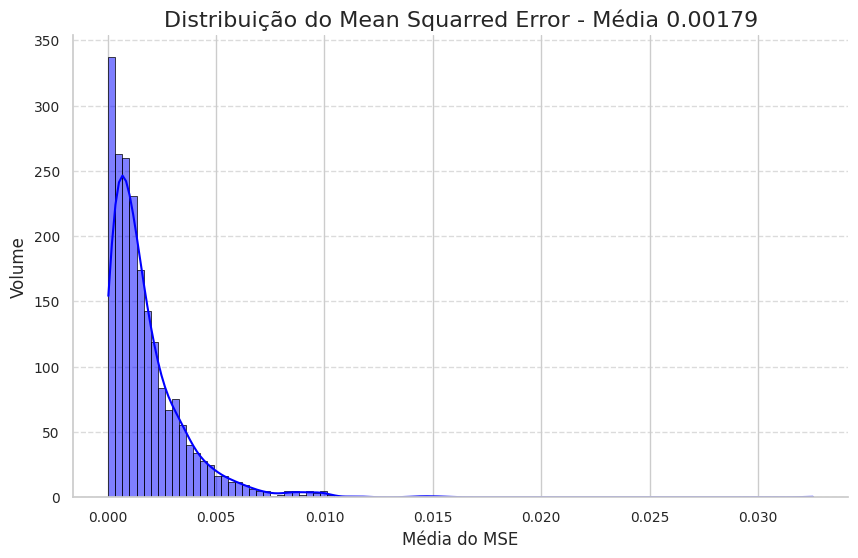

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Variância explicada: 0.8383 ou 83.83%


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

reconstructed_data = autoencoder.predict(X_test_temp)

# Calculate the reconstruction error for each data point
mse = np.mean(np.power(X_test_temp - reconstructed_data, 2), axis=1)


plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.histplot(mse, kde=True, bins=100, color='blue', edgecolor='black')  # Use histplot for distributions
plt.title(f'Distribuição do Mean Squarred Error - Média {mse.mean():0.5f}', fontsize=16)
plt.xlabel('Média do MSE', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() #remove top and right spines
plt.grid(axis='y', linestyle='--', alpha=0.7) # Customize gridlines
plt.show()


# Obter reconstruções
X_reconstruido = autoencoder.predict(X_test_temp)

# Calcular variância explicada
variancia_total = np.sum(np.var(X_test_temp, axis=0))
erro_reconstrucao = np.mean(np.sum((X_test_temp - X_reconstruido) ** 2, axis=1))
variancia_explicada = 1 - (erro_reconstrucao / variancia_total)

print(f"Variância explicada: {variancia_explicada:.4f} ou {variancia_explicada*100:.2f}%")

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


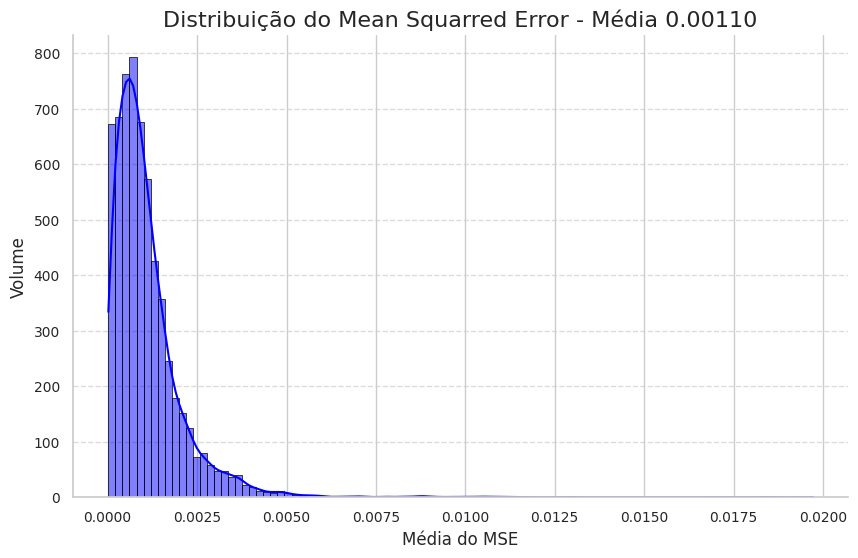

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Variância explicada: 0.9003 ou 90.03%


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

reconstructed_data = autoencoder.predict(X_train)

# Calculate the reconstruction error for each data point
mse = np.mean(np.power(X_train - reconstructed_data, 2), axis=1)


plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.histplot(mse, kde=True, bins=100, color='blue', edgecolor='black')  # Use histplot for distributions
plt.title(f'Distribuição do Mean Squarred Error - Média {mse.mean():0.5f}', fontsize=16)
plt.xlabel('Média do MSE', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() #remove top and right spines
plt.grid(axis='y', linestyle='--', alpha=0.7) # Customize gridlines
plt.show()


# Obter reconstruções
X_reconstruido = autoencoder.predict(X_train)

# Calcular variância explicada
variancia_total = np.sum(np.var(X_train, axis=0))
erro_reconstrucao = np.mean(np.sum((X_train - X_reconstruido) ** 2, axis=1))
variancia_explicada = 1 - (erro_reconstrucao / variancia_total)

print(f"Variância explicada: {variancia_explicada:.4f} ou {variancia_explicada*100:.2f}%")